Training Model...
Epoch 0, Loss: 491054434269265920.0000
Epoch 50, Loss: 491054434269265920.0000
Epoch 100, Loss: 491054434269265920.0000
Epoch 150, Loss: 491054296830312448.0000
Epoch 200, Loss: 491054228110835712.0000
Epoch 250, Loss: 491054021952405504.0000
Epoch 300, Loss: 491053815793975296.0000
Epoch 350, Loss: 491053369117376512.0000
Epoch 400, Loss: 491052785001824256.0000
Epoch 450, Loss: 491052063447318528.0000

Final Test MSE: 485845807170322432.0000

=== Trend Analysis ===
Average Streams - Explicit Songs: 445349873
Average Streams - Non-Explicit Songs: 448563230

Average Streams by Month:
Release Month
1     7.378117e+08
2     3.725042e+08
3     3.928157e+08
4     3.533444e+08
5     3.544407e+08
6     3.958114e+08
7     4.835472e+08
8     4.602664e+08
9     4.221754e+08
10    4.436782e+08
11    5.101806e+08
12    3.858484e+08
Name: Spotify Streams, dtype: float64


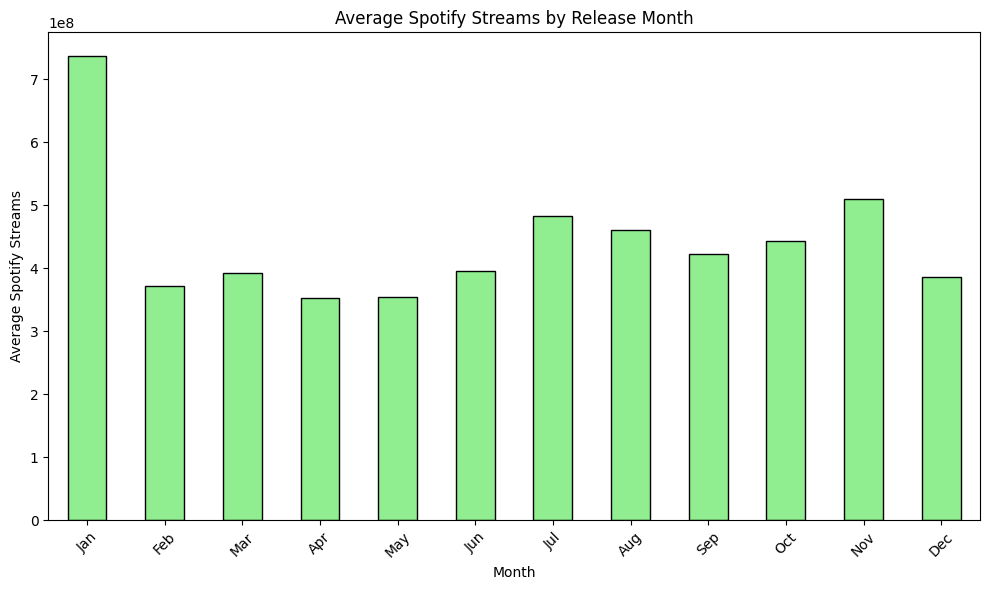


=== Predict Optimal Release Month for New Song ===
Recommended Release Month: 12


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/ut

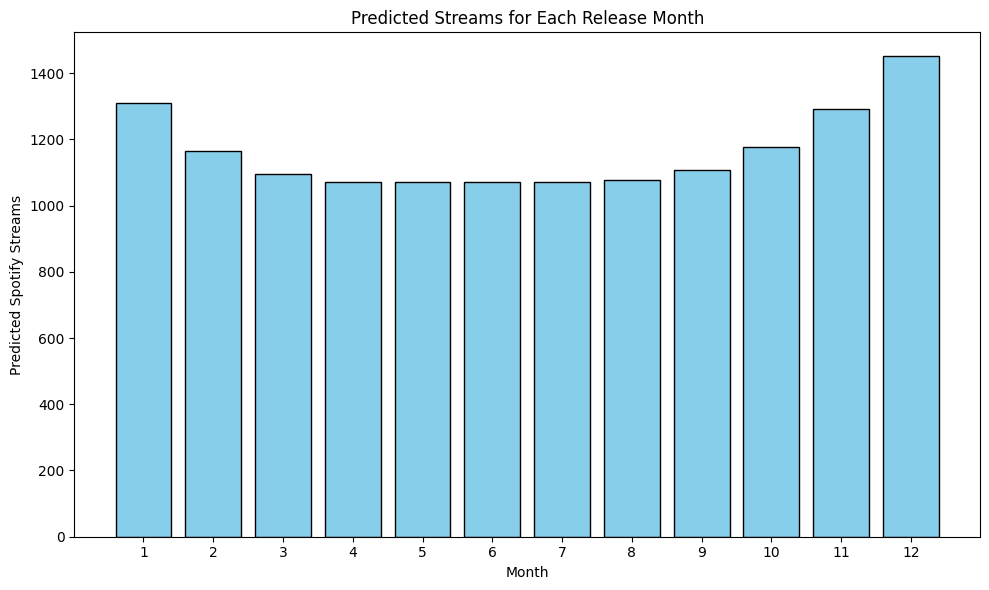

In [ ]:
import pandas as pd
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Load Dataset
csv_path = "/content/sample_data/Most Streamed Spotify Songs 2024.csv"
df = pd.read_csv(csv_path, encoding='latin1')

# Data Cleaning
df['Release Date'] = pd.to_datetime(df['Release Date'], errors='coerce')
df['Release Month'] = df['Release Date'].dt.month
df['Spotify Streams'] = df['Spotify Streams'].str.replace(',', '').astype(float)
df['Spotify Playlist Count'] = df['Spotify Playlist Count'].str.replace(',', '').astype(float)
df['Spotify Playlist Reach'] = df['Spotify Playlist Reach'].str.replace(',', '').astype(float)
df = df.dropna(subset=['Release Month', 'Spotify Streams'])  # Drop rows missing critical data

# Features and Target
X = df[['Release Month', 'Spotify Playlist Count', 'Spotify Playlist Reach', 'Explicit Track']].fillna(0)
y = df['Spotify Streams']

# Scale Features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_tensor = torch.tensor(X_scaled, dtype=torch.float32)
y_tensor = torch.tensor(y.values, dtype=torch.float32).view(-1, 1)

# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X_tensor, y_tensor, test_size=0.2, random_state=42)

# Define Neural Network
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(X_train.shape[1], 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

model = Net()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training Loop
print("Training Model...")
for epoch in range(500):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()
    if epoch % 50 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.4f}")

# Evaluation
model.eval()
with torch.no_grad():
    predictions = model(X_test)
    mse = criterion(predictions, y_test)
    print(f"\nFinal Test MSE: {mse.item():.4f}")

# Trend Analysis
print("\n=== Trend Analysis ===")

# Explicit Songs Performance
explicit_avg = df[df['Explicit Track'] == 1]['Spotify Streams'].mean()
non_explicit_avg = df[df['Explicit Track'] == 0]['Spotify Streams'].mean()
print(f"Average Streams - Explicit Songs: {explicit_avg:.0f}")
print(f"Average Streams - Non-Explicit Songs: {non_explicit_avg:.0f}")

# Average Streams by Month
month_avg = df.groupby('Release Month')['Spotify Streams'].mean()
print("\nAverage Streams by Month:")
print(month_avg)

# Plot Average Streams by Month
plt.figure(figsize=(10, 6))
month_avg.plot(kind='bar', color='lightgreen', edgecolor='black')
plt.title('Average Spotify Streams by Release Month')
plt.xlabel('Month')
plt.ylabel('Average Spotify Streams')
plt.xticks(ticks=range(0, 12), labels=[
    'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
    'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'
], rotation=45)
plt.tight_layout()
plt.show()

# Predict Optimal Release Month for New Song
def predict_streams_for_each_month(base_features):
    months = list(range(1, 13))
    predicted_streams = []

    for month in months:
        features = base_features.copy()
        features[0] = month  # Change release month
        scaled_features = scaler.transform([features])
        tensor_input = torch.tensor(scaled_features, dtype=torch.float32)
        with torch.no_grad():
            pred = model(tensor_input).item()
        predicted_streams.append(pred)

    return months, predicted_streams

# Example Song Features: [Release Month Placeholder, Playlist Count, Playlist Reach, Explicit(0 or 1)]
print("\n=== Predict Optimal Release Month for New Song ===")
example_song = [1, 10000, 5000000, 1]  # Example Song Characteristics
months, streams_predicted = predict_streams_for_each_month(example_song)

best_month = months[streams_predicted.index(max(streams_predicted))]
print(f"Recommended Release Month: {best_month}")

# Plot Predictions
plt.figure(figsize=(10, 6))
plt.bar(months, streams_predicted, color='skyblue', edgecolor='black')
plt.title('Predicted Streams for Each Release Month')
plt.xlabel('Month')
plt.ylabel('Predicted Spotify Streams')
plt.xticks(ticks=months)
plt.tight_layout()
plt.show()


Classification Report:

              precision    recall  f1-score   support

           0       0.95      0.99      0.97       807
           1       0.87      0.56      0.68        86

    accuracy                           0.95       893
   macro avg       0.91      0.77      0.83       893
weighted avg       0.95      0.95      0.94       893



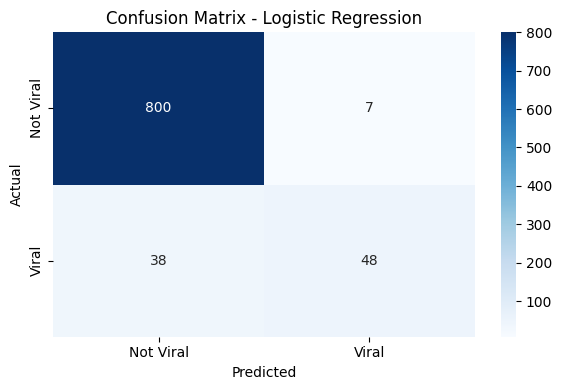

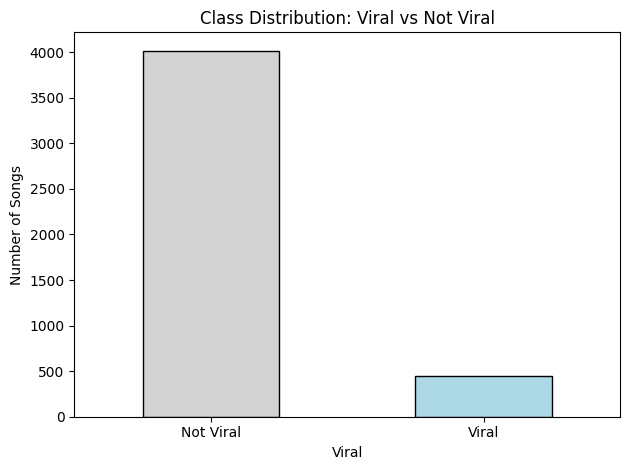

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

df = pd.read_csv("Spotify_Data.csv", encoding='latin1')

# 'Release Date' to datetime and extract month
df['Release Date'] = pd.to_datetime(df['Release Date'], errors='coerce')
df['Release Month'] = df['Release Date'].dt.month
df['Spotify Streams'] = df['Spotify Streams'].astype(str).str.replace(',', '').astype(float)
df['Spotify Playlist Count'] = df['Spotify Playlist Count'].astype(str).str.replace(',', '').astype(float)
df['Spotify Playlist Reach'] = df['Spotify Playlist Reach'].astype(str).str.replace(',', '').astype(float)

df = df.dropna(subset=['Spotify Streams', 'Spotify Playlist Count', 'Spotify Playlist Reach', 'Release Month'])

threshold = df['Spotify Streams'].quantile(0.90)
df['Viral'] = (df['Spotify Streams'] > threshold).astype(int)

features = ['Release Month', 'Spotify Playlist Count', 'Spotify Playlist Reach', 'Explicit Track']
X = df[features]
y = df['Viral']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Train Random Forest Regressor
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)

# Predict and evaluate
preds = clf.predict(X_test)
print("Classification Report:\n")
print(classification_report(y_test, preds))

cm = confusion_matrix(y_test, preds)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Viral', 'Viral'], yticklabels=['Not Viral', 'Viral'])
plt.title("Confusion Matrix - Logistic Regression")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

# feature importances
df['Viral'].value_counts().plot(kind='bar', color=['lightgray', 'lightblue'], edgecolor='black')
plt.xticks(ticks=[0,1], labels=['Not Viral', 'Viral'], rotation=0)
plt.title("Class Distribution: Viral vs Not Viral")
plt.ylabel("Number of Songs")
plt.tight_layout()
plt.show()


Random Forest - MSE: 74167733250802448.00
Random Forest - R² Score: 0.73


<ipython-input-13-edf41443cf2b>:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances, y=feature_names, palette='viridis')


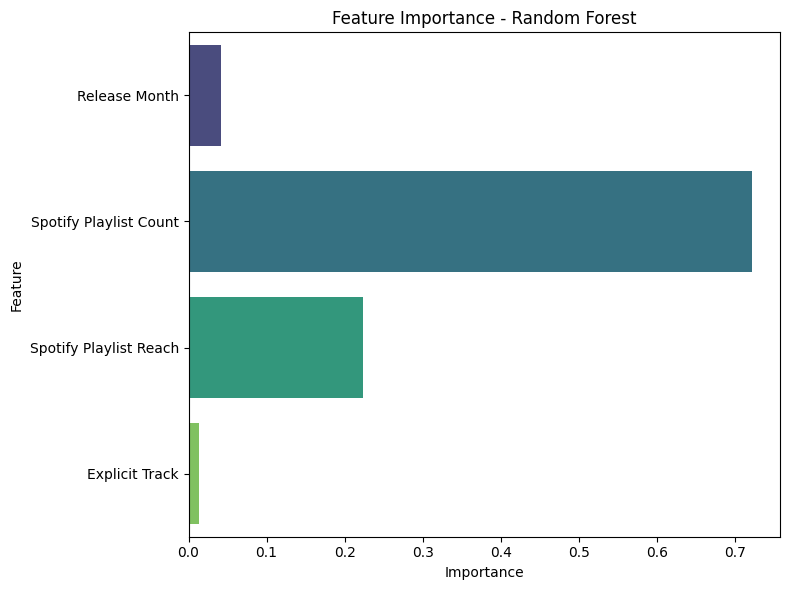

In [ ]:
df['Release Date'] = pd.to_datetime(df['Release Date'], errors='coerce')
df['Release Month'] = df['Release Date'].dt.month

df['Spotify Streams'] = df['Spotify Streams'].astype(str).str.replace(',', '').astype(float)
df['Spotify Playlist Count'] = df['Spotify Playlist Count'].astype(str).str.replace(',', '').astype(float)
df['Spotify Playlist Reach'] = df['Spotify Playlist Reach'].astype(str).str.replace(',', '').astype(float)

df = df.dropna(subset=['Spotify Streams', 'Spotify Playlist Count', 'Spotify Playlist Reach', 'Release Month'])

features = ['Release Month', 'Spotify Playlist Count', 'Spotify Playlist Reach', 'Explicit Track']
X = df[features]
y = df['Spotify Streams']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Train Random Forest Regressor
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Predict and evaluate
y_pred = rf.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Random Forest - MSE: {mse:.2f}")
print(f"Random Forest - R² Score: {r2:.2f}")

importances = rf.feature_importances_
feature_names = features

# Plot feature importances
plt.figure(figsize=(8, 6))
sns.barplot(x=importances, y=feature_names, palette='viridis')
plt.title("Feature Importance - Random Forest")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()